**Load necessary modules**

In [2]:
import numpy as np 
from scipy.integrate import odeint
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate as sr
import matplotlib.pyplot as plt
import pandas as pd
import sample as sm

**Run a single experiment and calculate forecast time for the L63 system**

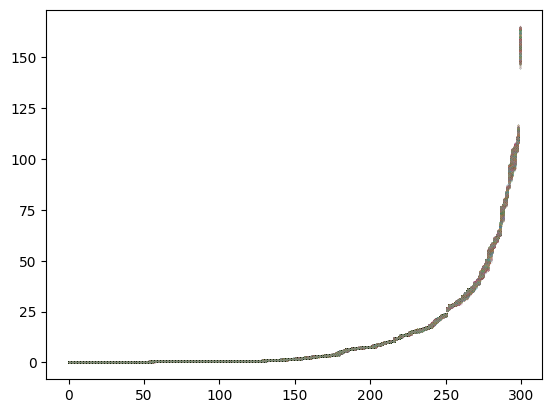

In [11]:
L63_data_folder = '../data/L63-trajectories'
train = np.load('{}/train.npy'.format(L63_data_folder))[:, :20000]
test = np.load('{}/test.npy'.format(L63_data_folder))[:, :, :500]
D, D_r = 3, 300
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05


sampler = sm.MatrixSampler(0.4, 3.5, train.T)
W_in, b_in = sampler.sample_([200, 50, 50])

W_in_fn = lambda d, d_r: W_in
b_in_fn = lambda d_r: b_in
surrogate = sr.SurrogateModel_LR(D, D_r, W_in_fn, b_in_fn)
surrogate.compute_W(train, beta=4e-8)
surrogate.compute_forecast_time(test, error_threshold, dt, Lyapunov_time)

#Visualize a predicted trajectory

# fig, N = plt.figure(figsize=(8, 8)), 200
# t = np.arange(0., N*dt, dt) / Lyapunov_time
# axs = [fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)]
# dims = ['x', 'y', 'z']
# # test = ape(1, 3, N)
# predicted = surrogate.multistep_forecast(test[1][:, 0], N)
# for i, ax in enumerate(axs):
#     ax.plot(t, test[1][i, :N], label='truth')
#     ax.plot(t, predicted[i, :N], label='predicted')
#     ax.legend(loc='upper right')
#     if i == len(dims)-1:
#         ax.set_xlabel('t')
#     ax.set_ylabel(dims[i])

# ax.set_zlabel('z')
# ax.set_title('Predicted trajectory')

data = []
u = train
for i in range(20000):
    phi = surrogate.phi(u[:, i])
    data.append(np.sort(np.sum(np.abs(surrogate.W * phi), axis=0)))
data = np.array(data)

for i in range(1000):
    plt.scatter(range(300), data[i, :], s=.01)
# plt.ylim(0., 2.)

(0.0, 2.0)

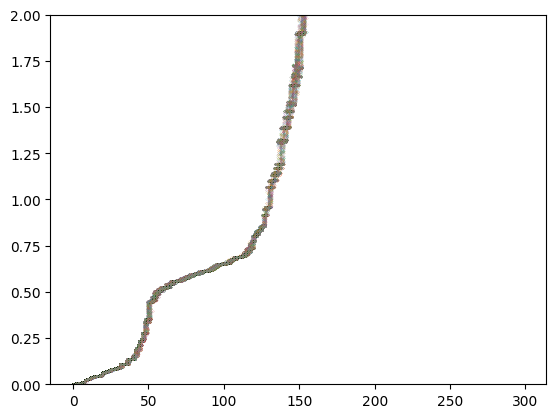

In [15]:
for i in range(1000):
    plt.scatter(range(300), data[i, :], s=.01)
plt.ylim(0., 2.)

**Run a batch of experiments and save data**

In [10]:
save_folder = '../data/L63-SMLR-2'
D, D_r = 3, 300
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05
beta = 4e-5
w_max, b_max = 0.4, 4.0
sqrt_n_models = 30
n_repeats = 10

L63_data_folder = '../data/L63-trajectories'
validation = np.load('{}/validation.npy'.format(L63_data_folder))[:, :300]
batch = sr.BatchUniform_SMLR(save_folder, D, D_r, w_max, b_max, sqrt_n_models, beta, error_threshold, dt, Lyapunov_time)
batch.run(train[:, :20000], n_repeats)

Time taken by run_single is 0.8502938747406006 seconds
Time taken by run_single is 0.900925874710083 seconds
Time taken by run_single is 0.8558080196380615 seconds
Time taken by run_single is 0.8460440635681152 seconds
Time taken by run_single is 0.8320341110229492 seconds
Time taken by run_single is 0.8460853099822998 seconds
Time taken by run_single is 0.8977069854736328 seconds
Time taken by run_single is 0.918222188949585 seconds
Time taken by run_single is 0.8650548458099365 seconds
Time taken by run_single is 0.9251556396484375 seconds
Time taken by run_single is 0.9848268032073975 seconds
Time taken by run_single is 0.9450607299804688 seconds
Time taken by run_single is 0.8353898525238037 seconds
Time taken by run_single is 0.9100120067596436 seconds
Time taken by run_single is 0.8033473491668701 seconds
Time taken by run_single is 0.7802858352661133 seconds
Time taken by run_single is 0.8995330333709717 seconds
Time taken by run_single is 0.9735658168792725 seconds
Time taken b

**Plot $\tau_f$**

Time taken by get_mean_std is 0.13083195686340332 seconds


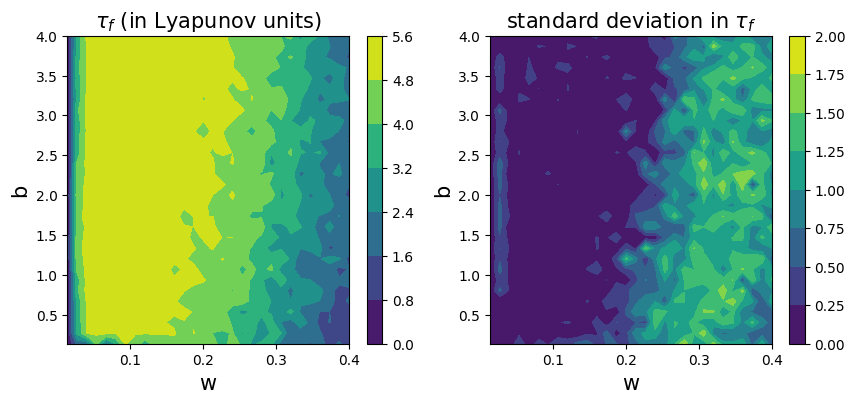

In [6]:
plot_folder = save_folder + '/plots'
scale = 0
xlabel_size = ylabel_size = 15 + scale
tick_size = 10 + scale
legend_size = 15 + scale
title_size = 15 + scale

bra = sr.BatchRunAnalyzer_SMLR(save_folder='../data/L63-SMLR-0')
data = bra.get_data()
tau_f, tau_f_sd = bra.get_mean_std('tau_f')


fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
ax_sd = fig.add_subplot(122)
w, b = batch.w, batch.b
# w, b = np.meshgrid(w, b)
# tau_f = np.genfromtxt(batch.tau_f_folder + '/tau_f_mean.csv', delimiter=',')
im = ax.contourf(w, b, tau_f.T, cmap='viridis')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=tick_size)
ax.set_xlabel('w', fontsize=xlabel_size)
ax.set_ylabel('b', fontsize=ylabel_size)
ax.set_title(r'$\tau_f$ (in Lyapunov units)', fontsize=ylabel_size)

# tau_f_sd = np.genfromtxt(batch.tau_f_folder + '/tau_f_std.csv', delimiter=',')
im = ax_sd.contourf(w, b, tau_f_sd.T, cmap='viridis')
cbar = fig.colorbar(im, ax=ax_sd)
cbar.ax.tick_params(labelsize=tick_size)
ax_sd.set_xlabel('w', fontsize=xlabel_size)
ax_sd.set_ylabel('b', fontsize=ylabel_size)
ax_sd.set_title(r'standard deviation in $\tau_f$', fontsize=ylabel_size)
plt.savefig('{}/tau_f.png'.format(plot_folder))
plt.show()

**$\tau_f$ vs Frobenius norm**

In [ ]:
fig = plt.figure(figsize=(14, 4))
ax_W_in = fig.add_subplot(131)
ax_b_in = fig.add_subplot(132)
ax_W = fig.add_subplot(133)

tau_f = np.genfromtxt(batch.tau_f_folder + '/tau_f_mean.csv', delimiter=',')
W_in_norm = np.genfromtxt(batch.W_in_folder + '/W_in_norm.csv', delimiter=',')
b_in_norm = np.genfromtxt(batch.b_in_folder + '/b_in_norm.csv', delimiter=',')
W_norm = np.genfromtxt(batch.W_folder + '/W_norm.csv', delimiter=',')

ax_W_in.scatter(W_in_norm, tau_f, c=tau_f)
ax_b_in.scatter(b_in_norm, tau_f, c=tau_f)
ax_W.scatter(W_norm, tau_f, c=tau_f)

ax_W_in.set_xlabel(r'$\|W_{\rm in}\|$', fontsize=xlabel_size)
ax_b_in.set_xlabel(r'$\|b_{\rm in}\|$', fontsize=xlabel_size)
ax_W.set_xlabel(r'$\|W\|$', fontsize=xlabel_size)

ax_W_in.set_ylabel(r'$\tau_f$', fontsize=ylabel_size)
ax_b_in.set_ylabel(r'$\tau_f$', fontsize=ylabel_size)
ax_W.set_ylabel(r'$\tau_f$', fontsize=ylabel_size)

plt.savefig('{}/tau_f_vs_norm.png'.format(plot_folder))
plt.show()

**$\tau_f$ vs zero rows and columns of W**

In [ ]:
ba = sr.BatchRunAnalyzer(save_folder)
zr, zc = ba.count_zero_W(bins=10)

fig = plt.figure(figsize=(8, 4))
ax_r = fig.add_subplot(121)
ax_c = fig.add_subplot(122)

df = pd.read_csv(save_folder + '/batch_data.csv')
tau_f = df['tau_f']
zr, zc = df['0-rows-W'], df['0-cols-W']

ax_r.scatter(zr, tau_f, c=tau_f)
ax_c.scatter(zc, tau_f, c=tau_f)
# ax_W.scatter(W_norm, tau_f, c=tau_f)

ax_r.set_xlabel('zero rows', fontsize=xlabel_size)
ax_r.set_ylabel(r'$\tau_f$', fontsize=ylabel_size)
ax_c.set_xlabel('zero cols', fontsize=xlabel_size)
ax_c.set_ylabel(r'$\tau_f$', fontsize=ylabel_size)
# ax_b_in.set_xlabel(r'$\|b_{\rm in}\|$', fontsize=xlabel_size)
# ax_W.set_xlabel(r'$\|W\|$', fontsize=xlabel_size)

# ax_W_in.set_ylabel(r'$\tau_f$', fontsize=ylabel_size)
# ax_b_in.set_ylabel(r'$\tau_f$', fontsize=ylabel_size)
# ax_W.set_ylabel(r'$\tau_f$', fontsize=ylabel_size)

plt.savefig('{}/tau_f_vs_zero.png'.format(plot_folder))
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
i, j, k = np.random.randint(30), np.random.randint(30), np.random.randint(10)

W = np.genfromtxt(save_folder + '/W/W_{}_{}_{}.csv'.format(i, j, k), delimiter=',')
counts, bins, _ = ax.hist(W.flatten(), bins=1000)
cmax = np.argmax(counts)
bins[cmax], bins[cmax+1]

In [ ]:
save_folder = '../data/L63-SMLR-1'
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
# ax_b = fig.add_subplot(122)

W_bad = np.genfromtxt('{}/W/W_14_29_6.csv'.format(save_folder), delimiter=',')
W_good = np.genfromtxt('{}/W/W_14_28_4.csv'.format(save_folder), delimiter=',')
ax.scatter(range(len(np.sum(W_bad, axis=0).flatten())), np.sum(W_bad**2, axis=0).flatten(), c='r', s=1, label='bad')
# ax.scatter(range(len(W_good.flatten())), W_good.flatten(), c='g', s=1,  label='good')
ax.set_ylim((0., .25))
ax.legend()

In [ ]:
L63_data_folder = '../data/L63-trajectories'
save_folder = '../data/L63-SMLR-4'
D, D_r = 3, 300
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05
beta = 1e-8
w_max, b_max = 0.4, 4.0
sqrt_n_models = 3
n_repeats = 2
train = np.load('{}/train.npy'.format(L63_data_folder))[:, :20000]
validation = np.load('{}/validation.npy'.format(L63_data_folder))[:, :300]
L63_data_folder = '../data/L63-trajectories'
data = np.load('{}/test.npy'.format(L63_data_folder))
batch = sr.BatchUniform_SMLR(save_folder, D, D_r, w_max, b_max, sqrt_n_models, beta, error_threshold, dt, Lyapunov_time)
batch.run(train, validation, n_repeats)